# Kaggle Competition Model

This notebook develops a machine learning model to predict whether a MercadoLibre product listing is new or used. The workflow includes data understanding, preprocessing, feature engineering, model selection, and final submission preparation.

In [29]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import joblib
import re

The dataset provided by MercadoLibre contains detailed information about listed items, stored in nested JSON format.
To prepare it for modeling, I first loaded the data using read_json() and then flattened the nested structure with pd.json_normalize(), expanding it into a tabular format with 56 columns.

In [16]:
# Load data
train = pd.read_json("train_data.jsonlines", lines=True)
test = pd.read_json("test_data.jsonlines", lines=True)
y = train["condition"].map({"used": 0, "new": 1})

In [17]:
# Flatten nested JSON columns
flat_data = pd.json_normalize(train.to_dict(orient="records"))

# Display the number of columns after flattening
print(f"Total columns after flattening: {flat_data.shape[1]}")
print(flat_data.columns.tolist())

Total columns after flattening: 56
['warranty', 'sub_status', 'condition', 'deal_ids', 'base_price', 'non_mercado_pago_payment_methods', 'seller_id', 'variations', 'site_id', 'listing_type_id', 'price', 'attributes', 'buying_mode', 'tags', 'listing_source', 'parent_item_id', 'coverage_areas', 'category_id', 'descriptions', 'last_updated', 'international_delivery_mode', 'pictures', 'id', 'official_store_id', 'differential_pricing', 'accepts_mercadopago', 'original_price', 'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created', 'secure_thumbnail', 'stop_time', 'status', 'video_id', 'catalog_product_id', 'subtitle', 'initial_quantity', 'start_time', 'permalink', 'sold_quantity', 'available_quantity', 'seller_address.country.name', 'seller_address.country.id', 'seller_address.state.name', 'seller_address.state.id', 'seller_address.city.name', 'seller_address.city.id', 'shipping.local_pick_up', 'shipping.methods', 'shipping.tags', 'shipping.free_shipping', 'shipping.mode', 

After flattening, I explored the condition variable, the target label that indicates whether an item is new or used.
To visualize class balance, I plotted the distribution of item condition, showing that the dataset is slightly imbalanced, with a higher proportion of used items. This step helps ensure that the model is later evaluated fairly and not biased toward the majority class.

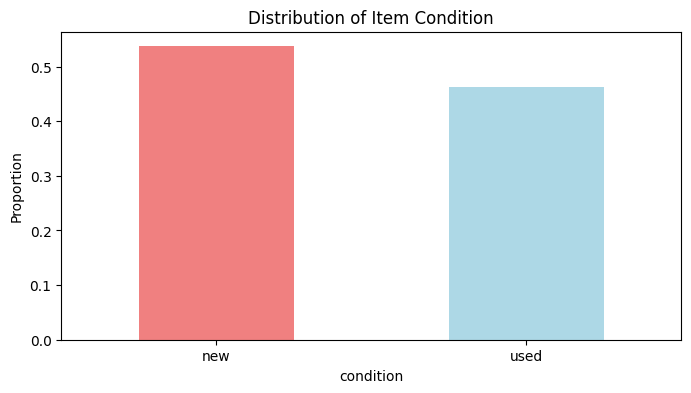

In [18]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8,4))
train["condition"].value_counts(normalize=True).plot(kind="bar", color=["lightcoral", "lightblue"])
plt.title("Distribution of Item Condition")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

Before modeling, it was essential to clean and standardize the raw text data. I defined two key preprocessing functions clean_text() and preprocess(), to ensure consistent and meaningful inputs across all feature types.

*clean_text()* handles text normalization by:
* converting all text to lowercase
* removing punctuation, special characters, URLs, and extra spaces
* normalizing accented characters (e.g., “á” → “a”).

This step ensures that the text data is clean, comparable, and suitable for TF-IDF vectorization later.

*preprocess()* combines both text and numeric feature engineering. It merges title and description into a single text column after cleaning, and creates several engineered numeric features such as:
* price ratios and discounts to reflect pricing behavior
* logarithmic transformations to reduce skewness
* demand ratios like sold_quantity / available_quantity

Together, these transformations capture both semantic meaning from text and economic patterns from numeric variables, providing the model with rich, interpretable information for classification.

In [19]:
def clean_text(text: str) -> str:
    """
    Lowercase, normalize, remove URLs/symbols/extra spaces
    
    Args:
        text (str): Input text string.
        
    Returns:
        str: Cleaned text string.
    """
    text = str(text).lower()
    text = unicodedata.normalize("NFKD", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z0-9áéíóúñü ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [20]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature engineering for both numeric and text
    
    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Preprocessed dataframe with new features
    """

    # Combine title + descriptions safely
    df["descriptions"] = df["descriptions"].apply(
        lambda x: " ".join(map(str, x)) if isinstance(x, list) else str(x)
    )
    df["title"] = df["title"].fillna("").apply(clean_text)
    df["descriptions"] = df["descriptions"].fillna("").apply(clean_text)
    df["text"] = df["title"] + " " + df["descriptions"]

    # Numeric and categorical engineered features
    df["price_ratio"] = df["price"] / (df["base_price"] + 1)
    df["discount_pct"] = (df["base_price"] - df["price"]) / (df["base_price"] + 1)
    df["is_discounted"] = (df["base_price"] > df["price"]).astype(int)
    df["sold_ratio"] = df["sold_quantity"] / (df["available_quantity"] + 1)
    df["price_diff"] = df["base_price"] - df["price"]
    df["log_price"] = np.log1p(df["price"].fillna(0))
    df["log_sold"] = np.log1p(df["sold_quantity"].fillna(0))
    df["discount_pct"] = (df["base_price"] - df["price"]) / (df["base_price"] + 1)
    df["inv_price_ratio"] = (df["available_quantity"] + 1) / (df["price"] + 1)
    df["price_per_sold"] = df["price"] / (df["sold_quantity"] + 1)

    return df

# Preprocess datasets
train = preprocess(train)
test = preprocess(test)

In [21]:
# Feature columns
text_col = "text"
num_cols = ["price", "base_price", "sold_quantity", "available_quantity",
            "price_ratio", "sold_ratio", "price_diff", "log_price"]
cat_cols = ["listing_type_id", "buying_mode", "category_id"]


Before defining the full preprocessing pipeline, I examined how the engineered numeric features relate to each other.
The correlation matrix helps identify redundant or highly correlated variables, which can introduce noise or multicollinearity in tree-based models. In this case, most features show low or moderate correlation, meaning they each capture distinct information about price, demand, and stock behavior.

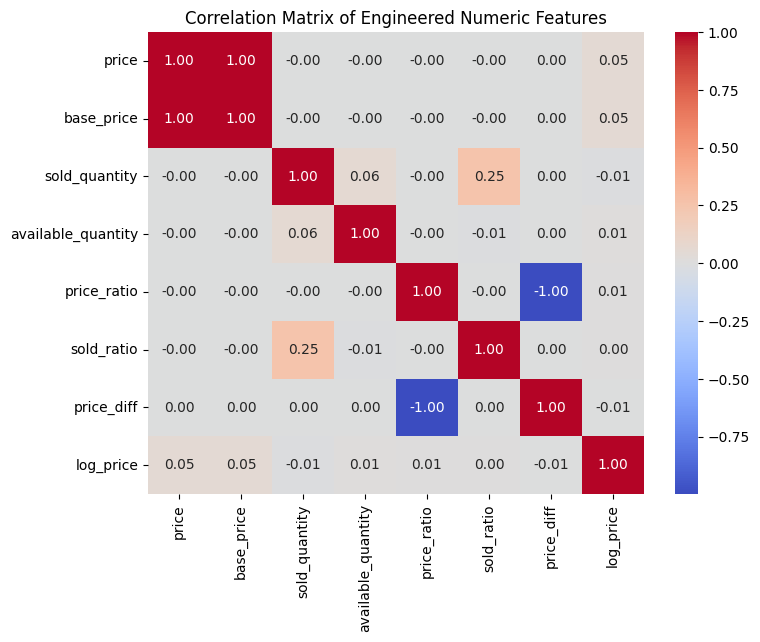

In [22]:
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Engineered Numeric Features")
plt.show()


Next, I defined preprocessing transformers for each feature type:

* **Text data:** 
Processed using a TF-IDF Vectorizer, which converts cleaned titles and descriptions into numerical word-weight vectors. I included unigrams, bigrams, and trigrams (ngram_range=(1,3)) to capture context while limiting to 30,000 features for efficiency.

* **Numeric features:**
Scaled with StandardScaler to normalize magnitudes and stabilize training.

* **Categorical features:** 
Encoded using OneHotEncoder, transforming category IDs into binary indicators.

These components were combined with a ColumnTransformer, ensuring that all feature groups were handled appropriately within a single preprocessing step, preventing data leakage and maintaining consistency.

In [23]:
# Preprocessing pipelines
text_transformer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    lowercase=True,
    strip_accents="unicode"
)

# Numerical transformer
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.3
)


After defining the preprocessing pipeline, I built and trained the classification model using **XGBoost**.
**XGBoost** is a gradient boosting algorithm known for its strong performance on structured datasets and its ability to model complex non-linear relationships.

Key parameters used:

* tree_method="hist" for faster histogram-based tree construction,

* learning_rate=0.03 and n_estimators=7000 for gradual learning,

* max_depth=9 to control tree complexity,

* subsample=0.85 and colsample_bytree=0.7 for regularization and generalization,

and reg_lambda, reg_alpha to penalize overfitting.

I integrated this model into a single scikit-learn Pipeline with two main steps:

* **Preprocessor:** applies all transformations consistently,

* **Classifier:** the final XGBoost model.

In [24]:
# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=7000,
    learning_rate=0.03,
    max_depth=9,
    subsample=0.85,
    colsample_bytree=0.7,
    reg_lambda=1.5,
    reg_alpha=0.5,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)


The dataset was split into an 80/20 train-validation set, and after training, I evaluated validation accuracy and saved the trained pipeline using joblib for reproducibility.

This modular design ensures a clean, reproducible workflow where preprocessing and modeling can be applied seamlessly to new data.

In [25]:
# Full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb_model)
])

In [26]:
# Train-validation split
X_tr, X_val, y_tr, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# Train and evaluate
pipeline.fit(X_tr, y_tr)
val_pred = pipeline.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Save the trained pipeline
joblib.dump(pipeline, "final_pipeline.pkl")

Validation Accuracy: 0.8900


['final_pipeline.pkl']

After training the **XGBoost** pipeline, I evaluated its performance using both quantitative metrics and visual diagnostics.
The validation accuracy reached 0.89, which indicates strong predictive performance on unseen data.

To ensure that the model’s behavior is consistent and not overfitted, I generated several diagnostic plots:

* **Confusion Matrix:** shows the counts of correctly and incorrectly classified items. Both “new” and “used” items are predicted with high accuracy and without major class imbalance.

* **Probability Distribution:** visualizes model confidence across predictions. The two clear peaks near 0 and 1 indicate the model is decisive, assigning strong probabilities to each class.

* **ROC Curve and Precision–Recall Curve:** evaluate the classifier across different thresholds. Both curves show high performance, with AUC and AP around 0.96, confirming excellent separability and precision.

These plots together demonstrate that the model generalizes well, makes confident and well-calibrated predictions, and shows no clear signs of overfitting.

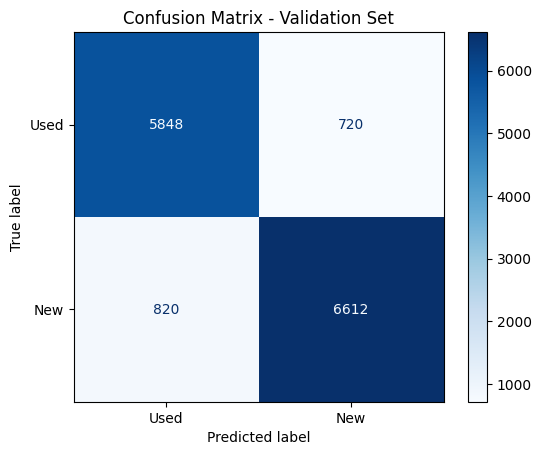

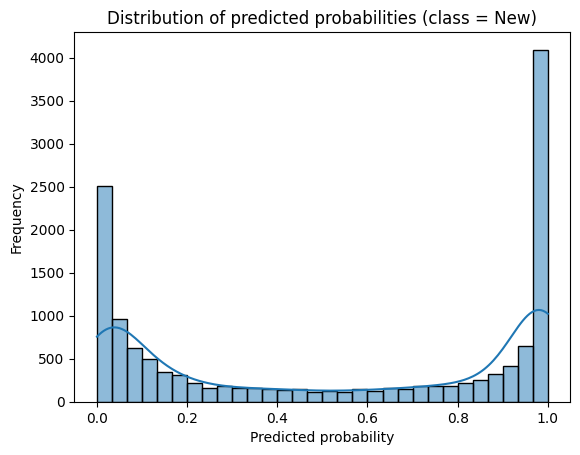

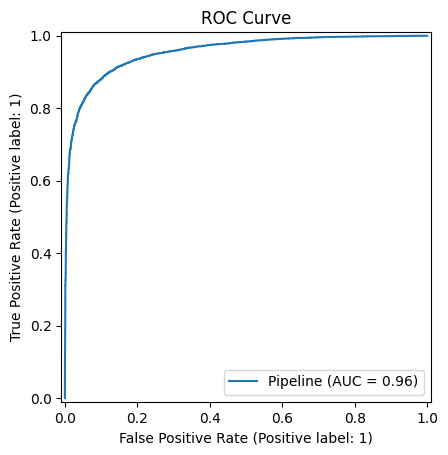

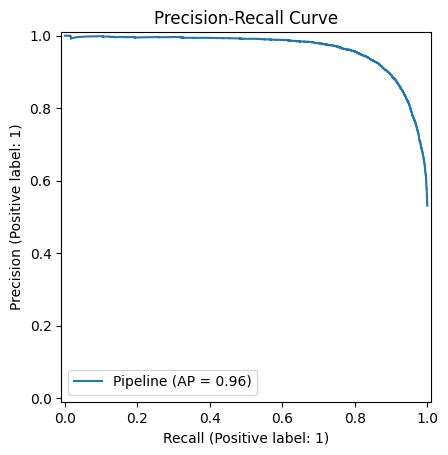

In [27]:
# Evaluation and sanity check plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Predicted probabilities and labels
val_pred = pipeline.predict(X_val)
val_proba = pipeline.predict_proba(X_val)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Used", "New"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Probability Distribution
sns.histplot(val_proba, kde=True, bins=30)
plt.title("Distribution of predicted probabilities (class = New)")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.show()

# ROC and Precision-Recall Curves
RocCurveDisplay.from_estimator(pipeline, X_val, y_val)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(pipeline, X_val, y_val)
plt.title("Precision-Recall Curve")
plt.show()


After confirming that the model performs well on the validation set, I used the trained pipeline to generate predictions on the test dataset.
The predictions were mapped back to their original categorical labels (“new” or “used”) to match the competition’s submission format.

A submission DataFrame was then created with two columns:

* **ID:** a sequential identifier for each test item,

* **condition:** the model’s predicted label (new or used).

Finally, the results were saved as submission.csv in the required Kaggle format.

In [28]:
# Predict on the test set
test_pred = pipeline.predict(test)
test_pred_labels = np.where(test_pred == 1, "new", "used")

# Prepare submission DataFrame
submission = pd.DataFrame({
    "ID": np.arange(1, len(test_pred_labels) + 1),
    "condition": test_pred_labels
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("submission.csv saved successfully in Kaggle format!")


submission.csv saved successfully in Kaggle format!
